In [1]:
import time

import pandas as pd
import numpy as np

import matplotlib
%matplotlib inline

from cataclop.ml.pipeline import factories

In [2]:
MAX_HISTORY = 6
NAN_FLAG = 10000.

In [3]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [4]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,138408.0,5.023770e+00,2.013027e+00,1.0,3.00,5.0,6.0,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,138408.0,1.233263e+01,3.128411e+00,3.0,10.00,12.0,15.0,2.400000e+01,int64
distance,138408.0,1.928350e+03,4.998067e+02,800.0,1600.00,2000.0,2300.0,6.856000e+03,int64
earnings,138408.0,5.909599e+06,1.784700e+07,0.0,490000.00,2027500.0,6045000.0,1.471275e+09,int64


In [5]:
df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight',
                'final_odds_ref'
               ] + ['hist_{}_pos'.format(i+1) for i in range(MAX_HISTORY)]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='left', on='race_id')

for f in agg_features:
    df['{}_r'.format(f)] = (df[f] - df['{}_mean'.format(f)]) / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features if f != 'final_odds_ref'] + ['{}_std'.format(f) for f in agg_features] + ['{}_mean'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(NAN_FLAG)


In [6]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

start = time.time()

odds = np.ones([len(df), 20]) * NAN_FLAG
idx = []

races = df.groupby('race_id')

j = 0
for (id, race) in races:
    jj = len(race.index)
    odds_sorted = np.array(sorted(race[race['final_odds_ref']>1.]['final_odds_ref'].values))
    
    
    
    odds[j:j+jj, 0:len(odds_sorted)] = odds_sorted[:20]
    
    idx = idx + list(race.index)
    
    j = j + jj
    
#scaler = StandardScaler()
#odds = scaler.fit_transform(odds)
    
odds_df = pd.DataFrame(odds, columns=['odds_{:d}'.format(i) for i in range(20)], index=idx)
df = pd.concat([df,odds_df], axis=1)

end = time.time()
print(end - start)

39.11021399497986


In [7]:
print(df['start_at'].min(), df['start_at'].max())

2017-01-01 12:40:00 2018-06-22 21:24:00


In [8]:
df['speed'] = (df['distance'] / df['time']).fillna(NAN_FLAG)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(NAN_FLAG)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.groupby('race_id').filter(lambda r: r['final_odds_ref'].min() > 0)
df = df.sort_index()
df_orig = df.copy()

In [9]:
#df_test = df_orig[(df_orig['start_at'] > '2018-06-01') & (df_orig['category']=='PLAT')].copy()
df_test = df_orig[(df_orig['start_at'] > '2018-06-07')].copy()
df = df_orig[(df_orig['start_at'] <= '2018-06-06')].copy()

df_test = df_test.sort_index()
df = df.sort_index()

In [10]:
pd.concat([pd.DataFrame(df.describe()).T, df.dtypes], axis=1, sort=True)

dff = df.reset_index()
pd.concat([pd.DataFrame(dff.describe()).T, dff.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,106780.0,5.036346e+00,2.025373e+00,1.000000e+00,3.000000e+00,5.000000e+00,6.000000e+00,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,106780.0,1.243496e+01,3.162771e+00,3.000000e+00,1.000000e+01,1.200000e+01,1.500000e+01,2.400000e+01,int64
distance,106780.0,1.926085e+03,5.155121e+02,8.000000e+02,1.500000e+03,2.000000e+03,2.300000e+03,6.856000e+03,int64
earnings,106780.0,6.188416e+06,1.809054e+07,0.000000e+00,6.241552e+05,2.365000e+06,6.572000e+06,1.389165e+09,int64


In [11]:
def random_race(df, cols=None, n=1):

    if cols is None:
        cols = ['position', 'sub_category', 'num', 'final_odds', 'final_odds_ref_r', 'final_odds_ref', 'hist_1_pos', 'hist_1_pos_r', 'hist_1_pos_mean', 'hist_1_pos_std', 'odds_0', 'odds_1']

    return df.reset_index().set_index(['race_id', 'index']).loc[np.random.permutation(df['race_id'].unique())[0:n]][cols]
    

In [12]:
random_race(df)

position sub_category  num  final_odds  final_odds_ref_r  \
race_id index                                                             
5966    41489       NaN    AUTOSTART    1        12.1         -0.510268   
        41490       2.0    AUTOSTART    2         3.7         -1.275671   
        41491       6.0    AUTOSTART    3        31.6          1.897271   
        41492       8.0    AUTOSTART    4        28.2         -0.231940   
        41493       1.0    AUTOSTART    5         4.7         -1.303504   
        41494       NaN    AUTOSTART    6        16.7          0.505630   
        41495       4.0    AUTOSTART    7         4.3         -0.385021   
        41496       NaN    AUTOSTART    8        11.1         -0.218024   
        41497       3.0    AUTOSTART    9        62.0          1.716357   
        41498       7.0    AUTOSTART   10        11.8         -0.468519   
        41499       5.0    AUTOSTART   11        25.3         -0.092776   
        41500       NaN    AUTOSTART   12        35.5          0.366466   

               final_odds_ref  hist_1_pos  hist_1_pos_r  hist_1_pos_mean  \
race_id index                                                              
5966    41489            10.0         8.0      1.252851         3.833333   
        41490             4.5         6.0      0.651482         3.833333   
        41491            27.3         0.0     -1.152623         3.833333   
        41492            12.0         0.0     -1.152623         3.833333   
        41493             4.3         6.0      0.651482         3.833333   
        41494            17.3         3.0     -0.250570         3.833333   
        41495            10.9         8.0      1.252851         3.833333   
        41496            12.1         6.0      0.651482         3.833333   
        41497            26.0         7.0      0.952166         3.833333   
        41498            10.3         2.0     -0.551254         3.833333   
        41499            13.0         0.0     -1.152623         3.833333   
        41500            16.3         0.0     -1.152623         3.833333   

               hist_1_pos_std  odds_0  odds_1  
race_id index                                  
5966    41489        3.325749     4.3     4.5  
        41490        3.325749     4.3     4.5  
        41491        3.325749     4.3     4.5  
        41492        3.325749     4.3     4.5  
        41493        3.325749     4.3     4.5  
        41494        3.325749     4.3     4.5  
        41495        3.325749     4.3     4.5  
        41496        3.325749     4.3     4.5  
        41497        3.325749     4.3     4.5  
        41498        3.325749     4.3     4.5  
        41499        3.325749     4.3     4.5  
        41500        3.325749     4.3     4.5

In [13]:
features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(10)]

#features = ['odds_{:d}'.format(i) for i in range(10)]

features

['race_count_r',
 'victory_count_r',
 'placed_2_count_r',
 'placed_3_count_r',
 'victory_earnings_r',
 'prev_year_earnings_r',
 'handicap_distance_r',
 'handicap_weight_r',
 'hist_1_pos_r',
 'hist_2_pos_r',
 'hist_3_pos_r',
 'hist_4_pos_r',
 'hist_5_pos_r',
 'hist_6_pos_r',
 'race_count_std',
 'victory_count_std',
 'placed_2_count_std',
 'placed_3_count_std',
 'victory_earnings_std',
 'prev_year_earnings_std',
 'handicap_distance_std',
 'handicap_weight_std',
 'final_odds_ref_std',
 'hist_1_pos_std',
 'hist_2_pos_std',
 'hist_3_pos_std',
 'hist_4_pos_std',
 'hist_5_pos_std',
 'hist_6_pos_std',
 'race_count_mean',
 'victory_count_mean',
 'placed_2_count_mean',
 'placed_3_count_mean',
 'victory_earnings_mean',
 'prev_year_earnings_mean',
 'handicap_distance_mean',
 'handicap_weight_mean',
 'final_odds_ref_mean',
 'hist_1_pos_mean',
 'hist_2_pos_mean',
 'hist_3_pos_mean',
 'hist_4_pos_mean',
 'hist_5_pos_mean',
 'hist_6_pos_mean',
 'declared_player_count',
 'hist_1_pos',
 'hist_2_pos',
 '

In [14]:
pd.options.display.max_columns = 200

In [15]:
random_race(df, ['final_odds_ref', 'winner_dividend'] + features)

final_odds_ref  winner_dividend  race_count_r  victory_count_r  \
race_id index                                                                   
4707    32312             7.0            500.0     -0.830380        -0.094750   
        32313             6.8              0.0     -1.130970        -0.805375   
        32314            12.7              0.0     -0.680085        -1.042250   
        32315             3.9              0.0      0.822865         0.142125   
        32316            34.3              0.0     -1.393986        -1.279125   
        32317            17.8              0.0      0.973160         0.379000   
        32318             9.4              0.0      1.236176         1.089625   
        32319             9.0              0.0     -0.003757        -0.094750   
        32320             6.0              0.0     -0.191626        -0.331625   
        32321            11.1              0.0      1.198603         2.037124   

               placed_2_count_r  placed_3_count_r  victory_earnings_r  \
race_id index                                                           
4707    32312          0.086562         -1.287174           -0.070962   
        32313         -0.779062         -0.572078           -0.873492   
        32314         -0.779062         -0.929626           -0.813494   
        32315          0.663646          1.215665            1.108318   
        32316         -1.644687         -1.287174           -1.267620   
        32317          0.375104          1.215665            0.418543   
        32318          0.375104          0.143019            1.600305   
        32319         -0.779062          0.143019           -0.412642   
        32320          0.663646          0.143019           -0.787922   
        32321          1.817812          1.215665            1.098966   

               prev_year_earnings_r  handicap_distance_r  handicap_weight_r  \
race_id index                                                                 
4707    32312              1.004401              10000.0           1.618342   
        32313             -0.800949              10000.0           1.618342   
        32314              0.495020              10000.0           0.502244   
        32315              1.285611              10000.0          -0.055805   
        32316             -1.181233              10000.0          -0.055805   
        32317             -1.181233              10000.0          -0.055805   
        32318              0.401950              10000.0          -0.613854   
        32319             -0.388140              10000.0          -0.613854   
        32320             -0.886012              10000.0          -1.171903   
        32321              1.250585              10000.0          -1.171903   

               hist_1_pos_r  hist_2_pos_r  hist_3_pos_r  hist_4_pos_r  \
race_id index                                                           
4707    32312     -0.520695      1.407515      0.000000     -1.247286   
        32313      0.280374     -1.185276     -1.279204     -0.992738   
        32314     -0.921229     -1.185276      0.639602      0.534551   
        32315      1.081443     -0.444478     -1.279204      1.043648   
        32316     -0.921229      0.666717     -1.279204      0.534551   
        32317     -0.921229      0.666717      1.279204      1.043648   
        32318     -0.921229      0.666717      0.959403     -0.992738   
        32319      0.280374     -1.185276      0.319801     -1.247286   
        32320      0.680908     -0.444478      0.959403      1.043648   
        32321      1.882512      1.037116     -0.319801      0.280003   

               hist_5_pos_r  hist_6_pos_r  race_count_std  victory_count_std  \
race_id index                                                                  
4707    32312     -1.171903     -0.820371       26.614324           4.221637   
        32313     -0.892878     -1.451426       26.614324           4.221637   
        32314      

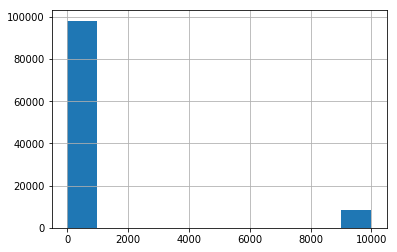

In [16]:

N_TARGETS = 20

df['target'] = np.log(1.+df['position'].copy())
df.loc[df['target'] > N_TARGETS, 'target'] = np.log(1.+N_TARGETS)
df['target'].fillna(NAN_FLAG, inplace=True)

#df['target'] = df['final_odds_ref'].fillna(df['final_odds_ref'].mean())

#df['target'] = df['winner_dividend'].fillna(0.)

#df['target'].fillna( NAN_FLAG, inplace=True )


#df['target'] = df['winner_dividend']/100.

#df['target'].fillna(NAN_FLAG, inplace=True)

df['target'].hist()



In [169]:
df['target'].describe()

count    106780.000000
mean        -10.938271
std         365.164477
min        -544.600000
25%         -30.900000
50%         -13.600000
75%          -6.300000
max       10000.000000
Name: target, dtype: float64

In [29]:
np.log(2.1)

0.7419373447293773

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df['race_id'].values

group_kfold = GroupKFold(n_splits=2)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'knn_5',
        'model': KNeighborsRegressor(n_neighbors=5),
        'scaler': True
    },
    {
        'name': 'knn_10',
        'model': KNeighborsRegressor(n_neighbors=10),
        'scaler': True
    },
    {
        'name': 'knn_30',
        'model': KNeighborsRegressor(n_neighbors=30),
        'scaler': True
    },
    {
        'name': 'knn_90',
        'model': KNeighborsRegressor(n_neighbors=150),
        'scaler': True
    },
    {
        'name': 'rf_10',
        'model': RandomForestRegressor(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestRegressor(n_estimators=100),
        'scaler': False
    },
]

for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0


In [176]:
d.players.index

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            144307, 144308, 144309, 144310, 144311, 144312, 144313, 144314,
            144315, 144316],
           dtype='int64', name='id', length=138408)

In [18]:

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)

        X_train = X_train[ (df.iloc[train_index]['target'] != NAN_FLAG) & (df.iloc[train_index]['final_odds_ref'] < 20) ]
        y_train = df['target'].iloc[train_index][ (df.iloc[train_index]['target'] != NAN_FLAG) & (df.iloc[train_index]['final_odds_ref'] < 20) ]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            #X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        '''
        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]
        '''
        
        p = clf.predict(X_test)
        
        df.loc[idx, 'pred_{}_1'.format(model['name'])] = p
        
        print( model['name'], mean_absolute_error(y_test.values, p) )
    
    
    
    

knn_5 804.6101369814307
knn_10 804.5962957699865
knn_30 804.588828172409
knn_90 804.5870853005591
rf_10 804.5784543116063
rf_100 804.5651556375919
knn_5 801.6123954943513
knn_10 801.599208709936
knn_30 801.5914827400275
knn_90 801.5887579355626
rf_10 801.5853282629832
rf_100 801.5701059974422


In [19]:
races = df.groupby('race_id')

N_TARGETS = 1

agg_preds = []

for i in range(N_TARGETS):
    for model in models:
        for s in ['mean', 'std', 'r']:
            col = 'pred_{}_{}_{}'.format(model['name'], i+1, s)
            if col in df.columns:
                df.drop(col, axis=1, inplace=True)
        
for i in range(N_TARGETS):
    for model in models:
        col = 'pred_{}_{}'.format(model['name'], i+1)
        agg_preds.append(col)
        
stats = races[agg_preds].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='left', on='race_id')

for f in agg_preds:
    col = '{}_r'.format(f)
    df[col] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_preds = ['{}_r'.format(f) for f in agg_preds] + ['{}_std'.format(f) for f in agg_preds] + ['{}_mean'.format(f) for f in agg_preds]

df[agg_preds] = df[agg_preds].replace([np.inf, -np.inf], np.nan)
df[agg_preds] = df[agg_preds].fillna(NAN_FLAG)


In [20]:
random_race(df, ['final_odds', 'position', 'final_odds_ref', 'final_odds', 'target'] + ['pred_{}_1'.format(model['name']) for model in models] +  ['pred_{}_1_mean'.format(model['name']) for model in models])

final_odds  position  final_odds_ref  final_odds    target  \
race_id index                                                               
8056    55087        40.9       8.0            14.2        40.9  2.197225   
        55088         5.5       1.0             5.7         5.5  0.693147   
        55089         5.9       3.0             5.3         5.9  1.386294   
        55090        12.3       7.0            12.2        12.3  2.079442   
        55091        12.5       4.0            13.6        12.5  1.609438   
        55092         2.5       5.0             2.9         2.5  1.791759   
        55093         4.7       2.0             5.7         4.7  1.098612   
        55094        25.2       6.0            13.5        25.2  1.945910   

               pred_knn_5_1  pred_knn_10_1  pred_knn_30_1  pred_knn_90_1  \
race_id index                                                              
8056    55087      1.499108       1.338165       1.523808       1.591066   
        55088      1.409851       1.334082       1.319628       1.496557   
        55089      1.396943       1.394126       1.575305       1.599317   
        55090      1.271222       1.337719       1.458671       1.523082   
        55091      1.279386       1.519402       1.554351       1.634516   
        55092      1.580201       1.338165       1.572318       1.602465   
        55093      1.396943       1.394126       1.575305       1.599317   
        55094      1.580201       1.315850       1.530034       1.595789   

               pred_rf_10_1  pred_rf_100_1  pred_knn_5_1_mean  \
race_id index                                                   
8056    55087      1.871642       1.692927           1.426732   
        55088      1.841082       1.455892           1.426732   
        55089      1.345861       1.441291           1.426732   
        55090      1.430590       1.605489           1.426732   
        55091      1.682083       1.639222           1.426732   
        55092      1.386407       1.391990           1.426732   
        55093      1.361276       1.475303           1.426732   
        55094      1.761781       1.715487           1.426732   

               pred_knn_10_1_mean  pred_knn_30_1_mean  pred_knn_90_1_mean  \
race_id index                                                               
8056    55087            1.371454            1.513678            1.580264   
        55088            1.371454            1.513678            1.580264   
        55089            1.371454            1.513678            1.580264   
        55090            1.371454            1.513678            1.580264   
        55091            1.371454            1.513678            1.580264   
        55092            1.371454            1.513678            1.580264   
        55093            1.371454            1.513678            1.580264   
        55094            1.371454            1.513678            1.580264   

               pred_rf_10_1_mean  pred_rf_100_1_mean  
race_id index                                         
8056    55087            1.58509              1.5522  
        55088            1.58509              1.5522  
        55089            1.58509              1.5522  
        55090            1.58509              1.5522  
        55091            1.58509              1.5522  
        55092            1.58509              1.5522  
        55093            1.58509              1.5522  
        55094            1.58509              1.5522

In [21]:
stacked_features = ['final_odds_ref'] + ['odds_{:d}'.format(i) for i in range(10)]
df['final_odds_ref'].fillna(NAN_FLAG, inplace=True)

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]
    
stacked_features = stacked_features + agg_preds# + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]

stacked_features =   stacked_features

stacked_features



['final_odds_ref',
 'odds_0',
 'odds_1',
 'odds_2',
 'odds_3',
 'odds_4',
 'odds_5',
 'odds_6',
 'odds_7',
 'odds_8',
 'odds_9',
 'pred_knn_5_1',
 'pred_knn_10_1',
 'pred_knn_30_1',
 'pred_knn_90_1',
 'pred_rf_10_1',
 'pred_rf_100_1',
 'pred_knn_5_1_r',
 'pred_knn_10_1_r',
 'pred_knn_30_1_r',
 'pred_knn_90_1_r',
 'pred_rf_10_1_r',
 'pred_rf_100_1_r',
 'pred_knn_5_1_std',
 'pred_knn_10_1_std',
 'pred_knn_30_1_std',
 'pred_knn_90_1_std',
 'pred_rf_10_1_std',
 'pred_rf_100_1_std',
 'pred_knn_5_1_mean',
 'pred_knn_10_1_mean',
 'pred_knn_30_1_mean',
 'pred_knn_90_1_mean',
 'pred_rf_10_1_mean',
 'pred_rf_100_1_mean']

In [23]:
from sklearn.linear_model import LogisticRegression
#from gplearn.genetic import SymbolicRegressor

N_TARGETS_STACKED = 20

df['target_stacked'] = df['position'].copy()

'''
df['target_stacked'] = df['target_stacked'] / df['declared_player_count']
df['target_stacked'].fillna(df['target_stacked'].mean(), inplace=True)
df['target_stacked'] = np.exp(1. + df['target_stacked'])
'''


#df['target_stacked'] = df['target_stacked'].apply(lambda r: 1 if r >= 1 and r <= 2 else r-1 if r > 2 else r  )

df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['target_stacked'] = df['target_stacked'].apply(lambda v: -1000 if v == 1 else v)


df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0

#df['target_stacked'] = np.ceil(1.+df['position'].fillna( 0. ))

df['target_stacked'] = df['winner_dividend'].fillna(0.)

#df['target_stacked'] = df['target'].copy()

df['target_stacked'].describe()

count    106780.000000
mean         77.619404
std         408.173569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18440.000000
Name: target_stacked, dtype: float64

In [611]:
df['target_stacked'].describe()

count    106780.000000
mean         77.619404
std         408.173569
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       18440.000000
Name: target_stacked, dtype: float64

In [24]:
from sklearn import linear_model

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[(df.iloc[train_index]['target_stacked'] != NAN_FLAG) & (df.iloc[train_index]['sub_category'] != 'fHANDICAP') & (df.iloc[train_index]['final_odds_ref'] < 20) ]
    y_train = df['target_stacked'].iloc[train_index][(df.iloc[train_index]['target_stacked'] != NAN_FLAG) & (df.iloc[train_index]['sub_category'] != 'fHANDICAP') & (df.iloc[train_index]['final_odds_ref'] < 20) ]

    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    #X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    #X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    #X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    #X_val = scaler.transform(X_val)
    
    '''
    clf = MLPClassifier(hidden_layer_sizes=(100), activation='tanh', batch_size=20)
    #clf = RandomForestClassifier(n_estimators=150)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    clf.fit(X_train, y_train.values)
    
    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    #p = clf.predict_proba(X_val)
    
    #for i in range(N_TARGETS_STACKED):
    #    df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]
    
    '''
       
    from sklearn.ensemble import RandomForestRegressor
    
    reg = linear_model.Ridge()
    #reg = MLPRegressor(hidden_layer_sizes=(50), activation='tanh')
    #reg = RandomForestRegressor(n_estimators=100)
    '''
    function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv', 'cos', 'sin',
                'max', 'min']
    from gplearn.fitness import make_fitness
    
    def _metric(y, y_pred, w):
        
        diffs = np.abs(np.divide((np.maximum(0.001, y) - np.maximum(0.001, y_pred)),
                             np.maximum(0.001, y)))
        return 100. * np.average(diffs, weights=w)        
    
    metric = make_fitness(_metric, greater_is_better=False)
    
    reg = SymbolicRegressor(function_set=function_set, 
                            verbose=True,
                            const_range=(-100, 100),
                            parsimony_coefficient=0.00001,
                            max_samples=0.8, metric=metric)
                        '''
    reg.fit(X_train, y_train.values)
    
    p = reg.predict(X_test)
    df.loc[idx, 'pred_stacked_1'] = p
    
    print( mean_absolute_error(y_test.values, p) )





154.58093925643306
13668532248.833895


In [25]:
random_race(df, cols=['position', 'final_odds_ref', 'winner_dividend', 'target_stacked', 'pred_stacked_1', 'pred_stacked_2', 'pred_stacked_3']).sort_values('pred_stacked_1')

position  final_odds_ref  winner_dividend  target_stacked  \
race_id index                                                               
14846   104963       6.0            70.9              0.0             0.0   
        104961       7.0            35.4              0.0             0.0   
        104968      11.0            31.5              0.0             0.0   
        104960       1.0             7.2            330.0           330.0   
        104965      12.0            31.8              0.0             0.0   
        104955       3.0            15.9              0.0             0.0   
        104959       8.0             3.1              0.0             0.0   
        104958       2.0            12.2              0.0             0.0   
        104956       5.0             7.9              0.0             0.0   
        104967       4.0             8.2              0.0             0.0   
        104964       9.0             8.4              0.0             0.0   
        104966      10.0             9.8              0.0             0.0   

                pred_stacked_1  pred_stacked_2  pred_stacked_3  
race_id index                                                   
14846   104963       69.242235             0.0             0.0  
        104961       69.602840             0.0             0.0  
        104968       73.781704             0.0             0.0  
        104960       74.283283             0.0             0.0  
        104965       76.417930             0.0             0.0  
        104955       79.418430             0.0             0.0  
        104959       80.276106             0.0             0.0  
        104958       80.531420             0.0             0.0  
        104956       85.879183             0.0             0.0  
        104967       88.573567             0.0             0.0  
        104964       90.017586             0.0             0.0  
        104966       90.327726             0.0             0.0

In [465]:
df['pred_stacked_1'].describe()

count    106780.000000
mean          0.769258
std           0.274968
min          -0.876774
25%           0.620471
50%           0.776391
75%           0.942086
max           2.381342
Name: pred_stacked_1, dtype: float64

In [26]:
fi = pd.Series(reg.feature_importances_, index=stacked_features)
print(fi.sort_values(ascending=False))

AttributeError: 'Ridge' object has no attribute 'feature_importances_'

In [27]:
df['pred_stacked_1'] = df['pred_rf_100_1']

In [51]:
#df_test['rnd'] = np.random.rand(len(df_tes))

#df['strat_1'] = df['pred_knn_150_1'] + df['pred_knn_30_1'] + df['pred_knn_10_1'] + df['pred_knn_5_1']
df['strat_1'] = -df['pred_knn_5_1'] * df['final_odds_ref']#df['pred_knn_5_1'] + df['pred_knn_10_1'] + df['pred_knn_30_1'] + df['pred_knn_150_1']

races = df.sort_values('start_at').groupby('race_id')

strats = ['strat_1']

bets = []

stash = 500

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(strats, 1):
        
#        if len(nums) > 0:
#            break

        r = race.sort_values(by=target, ascending=False)
    
        #r = r[r['final_odds_ref']<40.]
        
        odds = r['final_odds_ref'].min()
        nth = len(r[r['final_odds_ref']<odds])+1
    
        N = 5

        for n in range(N):
            
            if len(r) <= N:
                continue

            player = r.iloc[n]

            #if player['sub_category'] != 'COURSE_A_CONDITIONS':
            #    pass

            if player['num'] in nums:
                continue

            odds = player['final_odds_ref']
            nth = (r['final_odds_ref']<odds).sum()+1

            if np.isnan(odds) or odds > 20 or odds < 3:
                continue
                
            #if nth > 4:
            #    continue
                
            if race['final_odds_ref'].min() > 3:
                continue
                
            if race['final_odds_ref'].max() > 30:
                continue

            
            bet = min( 9., 1.5*np.floor(max(stash*0.01, 0.)) )
            
            bet = 1./player['declared_player_count']
            
            bet = np.floor(1+1/np.log(odds))
            
            bet = 1
        
            profit = player['winner_dividend']/100.0 * bet - bet
            
            stash = stash + profit

            #print(player['sub_category'], player['country'], player['declared_player_count'], player['final_odds_ref'], race['final_odds_ref'].describe())

            bets.append( (id, race['race_count'].min(), player['sub_category'], player['country'], player[target], nth, player['declared_player_count'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], race['final_odds_ref'].std(), player['num'], profit) )

            nums.append(player['num'])
            
            break



bets = pd.DataFrame(bets, columns=['id', 'race_count_min', 'cat', 'country', 'target', 'nth', 'n', 'date', 'bet', 'pos', 'odds', 'pred_1', 'num', 'odds_std', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['bets'] = bets['bet'].cumsum()
bets['stash'] = bets['profit'].cumsum()


In [52]:
bets_orig = bets.copy()

In [53]:


from cataclop.ml.exploration import loss_streak

bets = bets[(bets['profit']>0) | (bets['pos'] != 1)]
#bets = bets[bets['cat'] == 'COURSE_A_CONDITIONS']

print('from:', bets['date'].min(), 'to:', bets['date'].max())

print('loss streak:', loss_streak(bets))
print('bets:', (bets['bet']>0).sum())
print('bets:', bets['bet'].sum(), '€')
print('profits:', bets['profit'].sum(), '€')
print('returns:', 100. * (bets['profit'].sum() / bets['bet'].sum()), '%')
print('win rate:', 100. * (bets['profit']>0).astype('float').mean(), '%')

from: 2017-01-01 12:40:00 to: 2018-06-05 19:15:00
loss streak: 26
bets: 1150
bets: 1150 €
profits: -164.79999999999998 €
returns: -14.330434782608695 %
win rate: 19.73913043478261 %


In [30]:
bets[(bets['nth']<5.) & (bets['cat']=='AUTOSTART') & (bets['odds']>0)]['profit'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: profit, dtype: float64

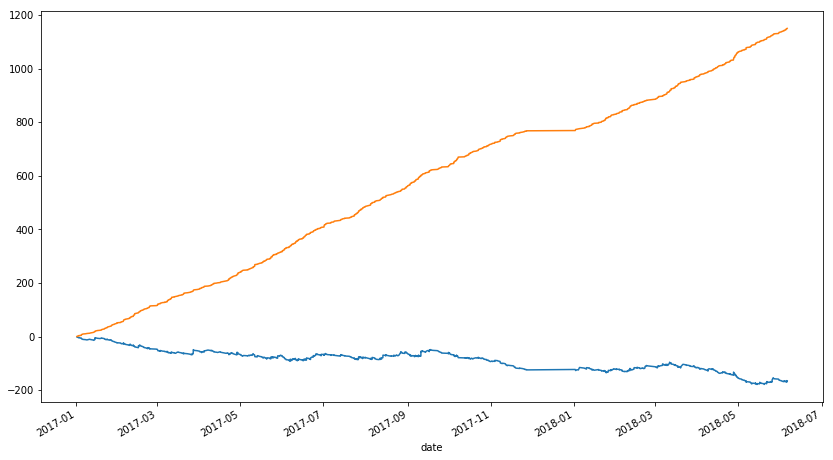

In [54]:
import matplotlib
%matplotlib inline

bb = bets.copy()#bets[(bets['nth']>1.) & (bets['cat']=='HANDICAP') & (bets['odds']>10)].copy()
#bb = bets[(bets['nth']>0.) & (bets['cat']!='HAjNDICAP') & (bets['odds']>0)].copy()

bb['stash'] = bb['profit'].cumsum()
bb['bets'] = bb['bet'].cumsum()

bb['stash'].plot()
bb['bets'].plot(figsize=(14,8))

cat     AUTOSTART  A_RECLAMER  COURSE_A_CONDITIONS  \
profit  -0.133333   -0.688889            -0.167925   
profit   3.000000    9.000000            53.000000   

cat     COURSE_A_CONDITION_QUALIF_HP  GROUPE_III   HANDICAP  \
profit                          -1.0        -1.0  -0.218182   
profit                           3.0         7.0  22.000000   

cat     HANDICAP_CATEGORIE_DIVISE  HANDICAP_DIVISE  
profit                       -1.0              1.7  
profit                        1.0              2.0  


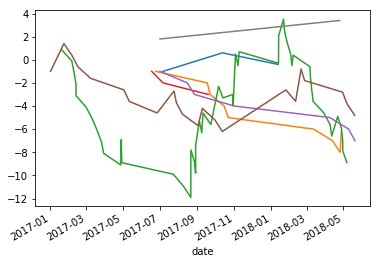

In [50]:
bets_cat = bb.groupby('cat')

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

for cat, b in bets_cat:
    (b['profit'].cumsum()).plot(label=cat)


In [555]:
bets['nth_r'] = bets['nth'] / bets['n']
bets[bets['profit']>0].describe()

,id,race_count_min,target,nth,n,bet,pos,odds,pred_1,num,odds_std,profit,bets,stash,nth_r
count,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.0,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000
mean,10192.978158,6.426401,0.881876,3.071225,10.708452,1.794872,1.0,7.021462,0.881876,31.354625,5.054131,6.958215,5782.771130,-1188.455935,0.293932
std,5677.036916,9.817031,0.293941,3.084929,2.952330,1.944499,0.0,9.964196,0.293941,233.557110,3.514489,11.068387,3341.472591,643.833186,0.258424
min,2.000000,0.000000,-0.396387,1.000000,4.000000,1.000000,1.0,1.100000,-0.396387,1.222020,1.000000,0.200000,1.000000,-2239.100000,0.050000
25%,5309.000000,0.000000,0.670629,1.000000,9.000000,1.000000,1.0,2.500000,0.670629,8.204734,2.000000,2.400000,2955.000000,-1664.500000,0.100000
50%,10448.000000,3.000000,0.915428,2.000000,11.000000,1.000000,1.0,3.900000,0.915428,13.207647,5.000000,3.900000,5921.000000,-1407.100000,0.181818
75%,15069.000000,8.000000,1.103573,4.000000,12.000000,2.000000,1.0,7.200000,1.103573,21.606266,7.000000,6.900000,8735.000000,-788.600000,0.400000
max,19814.000000,71.000000,1.646284,18.000000,20.000000,11.000000,1.0,116.800000,1.646284,5218.118388,18.000000,146.000000,11452.000000,120.300000,1.000000


In [446]:
bets[bets['profit']<0].describe()

,id,race_count_min,target,nth,n,bet,pos,odds,pred_1,num,odds_std,profit,bets,stash,nth_r
count,8805.000000,8805.000000,8805.000000,8805.000000,8805.000000,8805.000000,8102.000000,8804.000000,8805.000000,8.805000e+03,8805.000000,8805.000000,8805.000000,8805.000000,8805.000000
mean,10119.133901,6.823964,5.422371,6.936286,11.619307,0.089740,6.534683,30.301840,5.422371,1.606159e+01,6.646451,-0.089740,471.329983,-104.201959,0.600811
std,5608.114916,9.417141,1.720070,3.740462,3.215985,0.095418,3.210812,31.168135,1.720070,1.499637e+01,3.922645,0.095418,279.985778,52.279830,0.271836
min,1.000000,0.000000,-2.081153,1.000000,3.000000,0.001197,2.000000,1.100000,-2.081153,9.729507e-16,1.000000,-0.909091,0.055292,-180.234575,0.050000
25%,5358.000000,1.000000,4.400418,4.000000,9.000000,0.034364,4.000000,9.100000,4.400418,8.123401e+00,3.000000,-0.108696,220.383715,-141.728975,0.375000
50%,10257.000000,4.000000,5.449340,7.000000,11.000000,0.061350,6.000000,18.800000,5.449340,1.239029e+01,6.000000,-0.061350,467.741398,-130.425106,0.625000
75%,14841.000000,9.000000,6.646244,9.000000,14.000000,0.108696,9.000000,40.900000,6.646244,1.936627e+01,9.000000,-0.034364,717.645782,-56.964969,0.833333
max,19830.000000,75.000000,10.560480,23.000000,24.000000,0.909091,19.000000,374.600000,10.560480,3.089419e+02,18.000000,-0.001197,958.833369,3.581412,1.000000


In [106]:
bets[bets['odds']>15]['profit'].describe()

count    350.000000
mean       0.230286
std        5.265838
min       -1.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       35.200000
Name: profit, dtype: float64

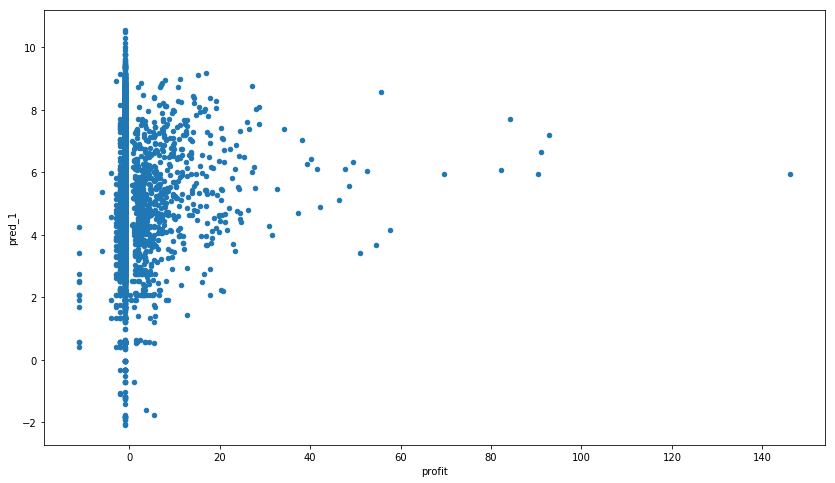

In [453]:
bets.plot.scatter(x='profit', y='pred_1', figsize=(14,8))

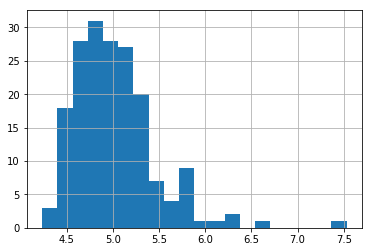

In [559]:
bets['pred_1'].hist(bins=20)

In [346]:
bets[['id', 'pos', 'odds', 'pred_1', 'profit', 'bet']]

,id,pos,odds,pred_1,profit,bet
date,,,,,,
2017-01-01 12:40:00,12368,2.0,6.6,4.251980,-1.0,1
2017-01-01 12:40:00,12368,5.0,6.9,4.046496,-1.0,1
2017-01-01 12:40:00,12368,7.0,14.7,3.984345,-1.0,1
2017-01-01 12:40:00,12368,3.0,3.7,3.719082,-1.0,1
2017-01-01 13:40:00,12370,1.0,2.1,5.371503,1.3,1
2017-01-01 13:40:00,12370,3.0,3.8,5.043530,-1.0,1
2017-01-01 13:40:00,12370,6.0,12.2,5.011389,-1.0,1
2017-01-01 14:27:00,12360,2.0,6.5,5.505355,-1.0,1
2017-01-01 14:27:00,12360,4.0,3.1,5.179737,-1.0,1


In [868]:
df[df['race_id']==4919][['position', 'winner_dividend']]

,position,winner_dividend
id,,
33925,7.0,0.0
33926,4.0,0.0
33927,3.0,0.0
33928,9.0,0.0
33929,2.0,0.0
33930,1.0,0.0
33931,5.0,0.0
33932,8.0,0.0
33933,6.0,0.0
